[link on youtube](https://www.youtube.com/watch?v=2mCfP6mpQpo)

In [2]:
import pandas as pd
import numpy as np
import os
import IPython.display as ipd
import librosa
import librosa.display
import matplotlib.pyplot as pit 
%matplotlib inline

### change path!

In [3]:
audio_dataset_path='D:\programming\pet Project\Alex\sound_classification\Data\genres_original' 
metadata = pd.read_csv('D:\\programming\\pet Project\\Alex\\sound_classification\\Data\\features_30_sec.csv') 
metadata.head ()

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.wav,661794,0.350088,0.088757,0.130228,0.002827,1784.165850,129774.064525,2002.449060,85882.761315,...,52.420910,-1.690215,36.524071,-0.408979,41.597103,-2.303523,55.062923,1.221291,46.936035,blues
1,blues.00001.wav,661794,0.340914,0.094980,0.095948,0.002373,1530.176679,375850.073649,2039.036516,213843.755497,...,55.356403,-0.731125,60.314529,0.295073,48.120598,-0.283518,51.106190,0.531217,45.786282,blues
2,blues.00002.wav,661794,0.363637,0.085275,0.175570,0.002746,1552.811865,156467.643368,1747.702312,76254.192257,...,40.598766,-7.729093,47.639427,-1.816407,52.382141,-3.439720,46.639660,-2.231258,30.573025,blues
3,blues.00003.wav,661794,0.404785,0.093999,0.141093,0.006346,1070.106615,184355.942417,1596.412872,166441.494769,...,44.427753,-3.319597,50.206673,0.636965,37.319130,-0.619121,37.259739,-3.407448,31.949339,blues
4,blues.00004.wav,661794,0.308526,0.087841,0.091529,0.002303,1835.004266,343399.939274,1748.172116,88445.209036,...,86.099236,-5.454034,75.269707,-0.916874,53.613918,-4.404827,62.910812,-11.703234,55.195160,blues


In [86]:
def features_extractor(file):
    '''this function return features for neural network
    download file -> extract the feature -> mean of these -> return'''
    audio, sample_rate = librosa.load(file)
    mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40) 
    mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)
    return mfccs_scaled_features

In [6]:
metadata.drop(labels=552, axis=0, inplace=True)

In [9]:
from tqdm import tqdm
### Now we iterate through every audio file and extract features
### using Hel-Frequency Cepstral Coefficients
extracted_features=[]
for index_num,row in tqdm(metadata.iterrows()):
    try:
        final_class_labels=row["label"]
        file_name = os.path.join(os.path.abspath(audio_dataset_path), final_class_labels+'/',str(row["filename"])) 
        data=features_extractor(file_name)
        extracted_features.append([data, final_class_labels])
    except Exception as e: 
        print(f"Error: {e}") 
        continue

552it [00:22, 30.51it/s]C:\Users\user\AppData\Local\Temp\ipykernel_11424\3446191290.py:2: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(file, res_type='kaiser_fast')
556it [00:22, 30.94it/s]

Error: 


999it [00:40, 24.78it/s]


In [10]:
extracted_features_df=pd.DataFrame(extracted_features,columns=['feature','class']) 
extracted_features_df.head()

,feature,class
0,"[-113.59882, 121.57067, -19.162262, 42.36394, ...",blues
1,"[-207.52383, 123.98514, 8.947019, 35.86715, 2....",blues
2,"[-90.757164, 140.44087, -29.084547, 31.686693,...",blues
3,"[-199.57513, 150.0861, 5.663404, 26.855278, 1....",blues
4,"[-160.35417, 126.20948, -35.581394, 22.139256,...",blues


In [11]:
extracted_features_df['class'].value_counts()

class
blues        100
classical    100
country      100
disco        100
hiphop       100
metal        100
pop          100
reggae       100
rock         100
jazz          98
Name: count, dtype: int64

In [13]:
X = np.array(extracted_features_df['feature'].tolist())
y = np.array(extracted_features_df['class'].tolist())
X.shape

(998, 40)

In [15]:
from tensorflow.keras.utils import to_categorical 
from sklearn.preprocessing import LabelEncoder 
labelencoder=LabelEncoder()
y=to_categorical(labelencoder.fit_transform(y))

In [16]:
y.shape

(998, 10)

In [17]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=0)

In [18]:
print(f'{X_train.shape}\n{X_test.shape}\n{y_train.shape}\n{y_test.shape}')

(798, 40)
(200, 40)
(798, 10)
(200, 10)


In [20]:
import tensorflow as tf 
print(tf.__version__)

2.16.1


In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Activation,Flatten
from tensorflow.keras.optimizers import Adam
from sklearn import metrics

In [23]:
num_labels = y.shape[1]
num_labels

10

In [24]:
model=Sequential()
model.add(Dense(1024,input_shape=(40,), activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(512, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(256, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(128, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(32, activation="relu"))
model.add(Dropout(0.3))
###final layer
model.add(Dense(num_labels, activation="softmax"))

d:\Distrib\conda\envs\deeplearning\lib\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [25]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 1024)           │        41,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 741,674 (2.83 MB)

 Trainable params: 741,674 (2.83 MB)

 Non-trainable params: 0 (0.00 B)

In [26]:
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

In [27]:
import time 
t = time.localtime() 
current_time = time.strftime("%H:%M:%S", t)

In [46]:
from tensorflow.keras.callbacks import ModelCheckpoint
from datetime import datetime

num_epochs = 100
num_batch_size = 32
checkpointer = ModelCheckpoint(filepath=f'saved_models/audio_classification.keras', verbose=1, save_best_only=True)

start = datetime.now()

history = model.fit(X_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(X_test, y_test), callbacks=[checkpointer],verbose=1)
duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/100
23/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8102 - loss: 0.5675
Epoch 1: val_loss improved from inf to 2.04195, saving model to saved_models/audio_classification.keras
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8090 - loss: 0.5702 - val_accuracy: 0.5750 - val_loss: 2.0420
Epoch 2/100
23/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7910 - loss: 0.6975
Epoch 2: val_loss improved from 2.04195 to 2.01657, saving model to saved_models/audio_classification.keras
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7907 - loss: 0.6941 - val_accuracy: 0.5450 - val_loss: 2.0166
Epoch 3/100
24/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7809 - loss: 0.6740
Epoch 3: val_loss did not improve from 2.01657
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7821 - loss: 0.6737 - val_accuracy: 0.5700 - val_loss: 2.0877
Epoch 4/100
23/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8161 - loss: 0.6233
Epoch 4: val_loss did not improve from 2.01657
25/25 ━

In [47]:
model.evaluate(X_test, y_test, verbose=0)

[3.081435441970825, 0.6100000143051147]

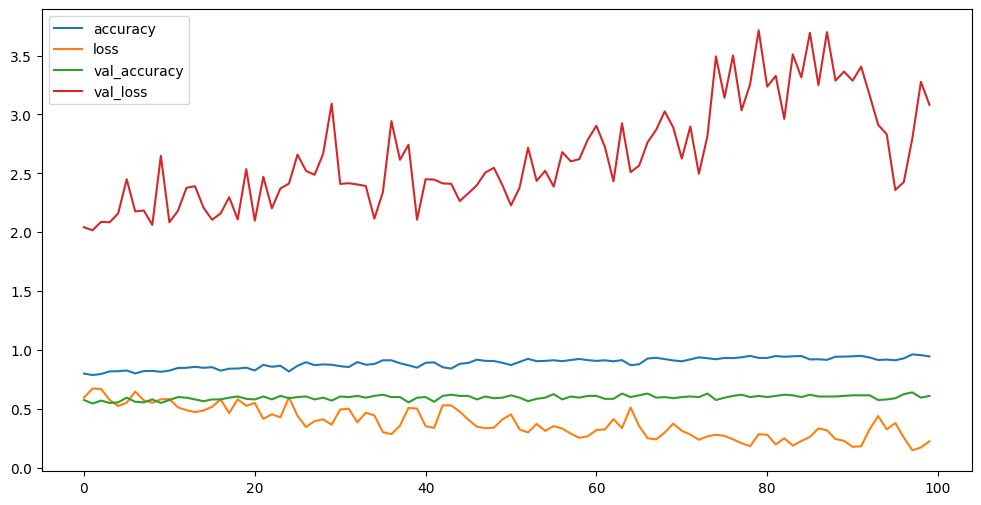

In [50]:
from matplotlib import pyplot as plt

pd.DataFrame(history.history).plot(figsize=(12,6))
plt.show()

In [44]:
predict_x = model.predict(X_test) 
classes_x=np.argmax(predict_x,axis=1)
classes_x

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


array([2, 7, 0, 3, 6, 7, 5, 8, 8, 2, 6, 4, 1, 1, 5, 7, 6, 5, 3, 0, 4, 5,
       8, 0, 1, 7, 5, 2, 2, 6, 7, 4, 0, 4, 6, 6, 9, 5, 2, 7, 9, 9, 3, 9,
       0, 8, 4, 3, 5, 6, 5, 8, 6, 5, 2, 2, 9, 2, 3, 6, 6, 8, 0, 9, 7, 2,
       1, 4, 9, 1, 6, 3, 9, 0, 4, 9, 2, 4, 6, 0, 2, 6, 8, 3, 2, 5, 2, 8,
       8, 2, 4, 0, 9, 4, 6, 7, 7, 5, 0, 2, 5, 2, 4, 8, 1, 4, 7, 4, 1, 6,
       0, 4, 3, 4, 6, 9, 4, 6, 3, 2, 4, 8, 2, 9, 2, 7, 1, 8, 0, 7, 8, 9,
       5, 4, 1, 8, 2, 4, 2, 2, 9, 3, 0, 0, 3, 0, 4, 7, 4, 3, 6, 8, 3, 8,
       8, 6, 4, 3, 4, 8, 9, 5, 9, 4, 7, 1, 7, 2, 7, 5, 8, 6, 1, 7, 7, 1,
       4, 7, 2, 3, 9, 4, 9, 2, 7, 8, 2, 6, 3, 7, 6, 6, 1, 2, 8, 9, 6, 9,
       2, 1], dtype=int64)

## FINAL PREDICT, CHANGE FILEPATH ON CUSTOM

In [90]:
filename = "D:\programming\pet Project\Alex\sound_classification\Vadzim\classic_check.wav"

# Reshape to (1, -1) for compatibility with model input
mfccs_scaled_features = features_extractor(filename).reshape(1, -1)

predicted_label = model.predict(mfccs_scaled_features) 
classes_x = np.argmax(predicted_label, axis=1)

print(classes_x)

# Use classes_x to get the prediction class
prediction_class = labelencoder.inverse_transform(classes_x) 
print(prediction_class)


[[-1.6799733e+02  1.3500122e+02 -5.0421181e+01  3.4876377e+01
  -1.4078425e+01 -1.0093562e+01 -5.2626281e+00 -6.2303696e+00
  -4.7668176e+00 -7.5556107e+00 -9.6147995e+00 -4.9359770e+00
  -4.0797620e+00 -2.4207299e+00 -2.7301633e+00  1.4063145e+00
  -3.0856807e+00 -1.8367600e+00 -3.3835084e+00 -4.8268275e+00
  -4.1095395e+00 -3.7654712e+00 -9.2942911e-01  2.9581127e+00
   1.1544499e+00 -1.2298750e+00 -2.5869613e+00 -3.2051969e+00
  -3.2610481e+00  8.7415808e-01 -2.3887067e+00 -7.0701408e+00
  -5.1141152e+00  7.9615319e-01 -5.5075034e-02  1.5757134e+00
  -3.3067868e+00 -2.8631961e+00 -3.8096659e+00 -5.0492592e+00]]
(1, 40)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
[1]
['classical']
